![nsdf](https://www.sci.utah.edu/~pascucci/public/NSDF-large.png)  
[National Science Data Fabric](https://nationalsciencedatafabric.org/) 

# Converting HDF5 data

In [3]:
import os ,sys, time, logging,shutil
from datetime import datetime
import numpy as np
import boto3
import h5py
from pprint import pprint

def Traverse(cur):
    if isinstance(cur,h5py.Dataset):
        return {
            '__type':type(cur),
            'shape':cur.shape,
            'dtype':cur.dtype,
            'size':cur.size,
            'ndim':cur.ndim,
            'nbytes':cur.nbytes,
        }
    else:
        return {key: Traverse(cur[key])for key in cur.keys()}

f = h5py.File('/mnt/data/chess/assets/ff1_000231.h5', 'r') 
pprint(Traverse(f))

{'imageseries': {'images': {'__type': <class 'h5py._hl.dataset.Dataset'>,
                            'dtype': dtype('uint16'),
                            'nbytes': 34517975040,
                            'ndim': 3,
                            'shape': (1445, 3888, 3072),
                            'size': 17258987520},
                 'instrument': {'NDAttributes': {'NDArrayEpicsTSSec': {'__type': <class 'h5py._hl.dataset.Dataset'>,
                                                                       'dtype': dtype('uint32'),
                                                                       'nbytes': 5780,
                                                                       'ndim': 1,
                                                                       'shape': (1445,),
                                                                       'size': 1445},
                                                 'NDArrayEpicsTSnSec': {'__type': <class 'h5py._hl.dataset.Dataset'>,

# Read binary data

A single dataset is 33GB. 

**Better to now load all in memory**; here I am reading only a little portion

Images dtype=uint16 shape=(1445, 3888, 3072) 
<class 'slice'> <class 'slice'>
dtype float64 shape (3888, 3072) m 8.372449417009602e-08 M 1.0


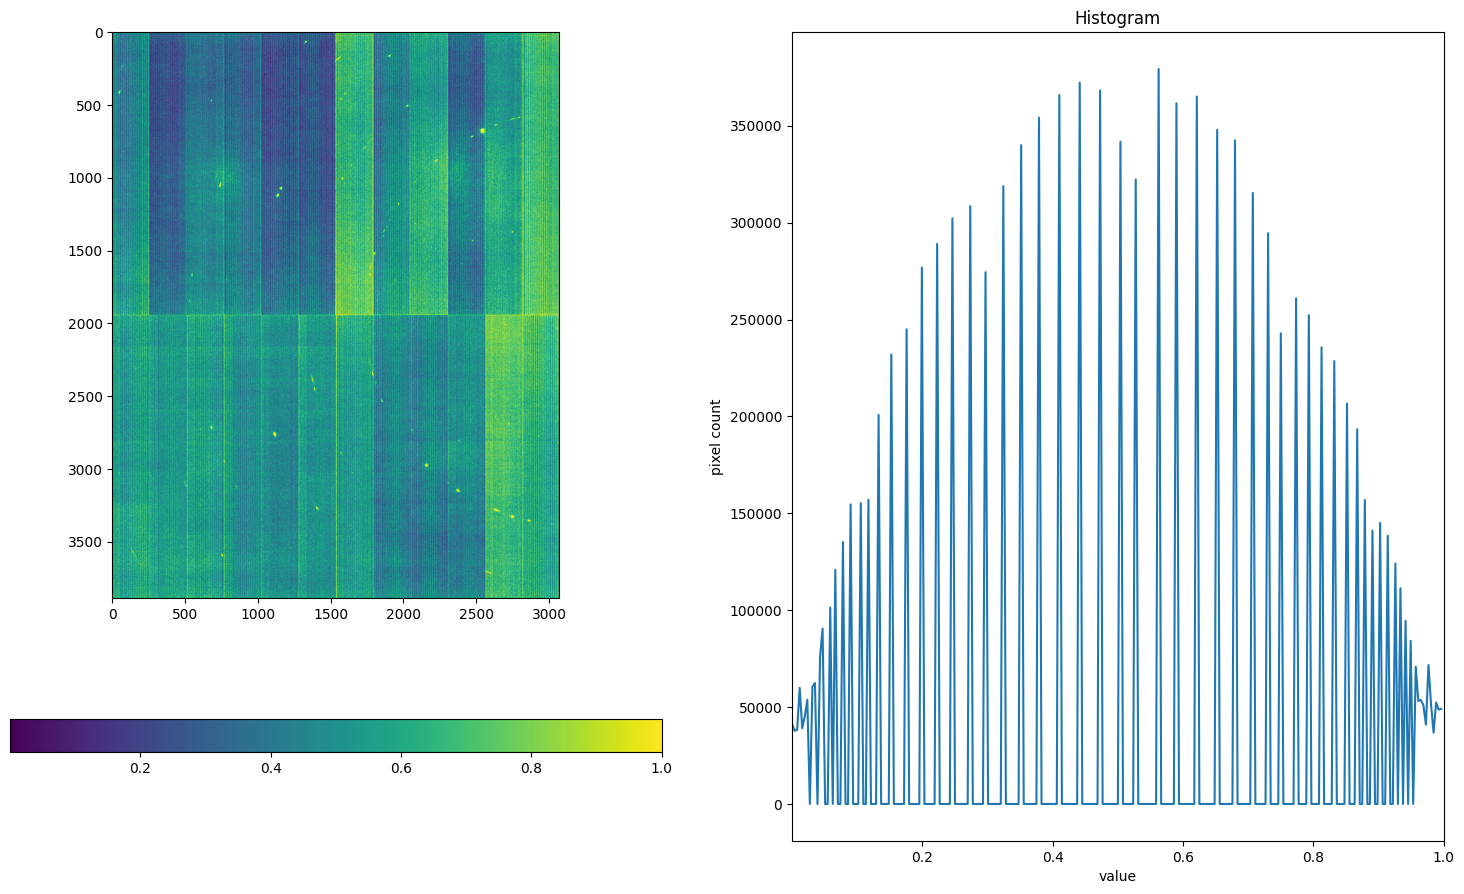

In [4]:
import matplotlib.pyplot as plt
from scipy import ndimage
from matplotlib.colors import LogNorm

# ///////////////////////////////////////////////////////////////
def ShowImage(img, histogram=True):
	print("dtype",img.dtype,"shape",img.shape,"m",np.min(img),"M",np.max(img))
	fig = plt.figure()
	fig.set_size_inches(18.5, 10.5)

	ax = fig.add_subplot(1, 2, 1) # nrows, ncols, index
	imgplot = plt.imshow(img)

	plt.colorbar(orientation='horizontal')
	if histogram:
		ax = fig.add_subplot(1, 2, 2)
		histogram, bin_edges = np.histogram(img, bins=256, range=(np.min(img), np.max(img)))
		plt.title("Histogram")
		plt.xlabel("value")
		plt.ylabel("pixel count")
		plt.xlim([np.min(img), np.max(img)])
		plt.plot(bin_edges[0:-1], histogram)


images=f["imageseries"]["images"]
D,H,W=images.shape
print(f"Images dtype={images.dtype} shape={images.shape} ")

Z=300
img=images[Z,:,:]
print(np.min(slice),np.max(slice))

from skimage import io,exposure
ShowImage(exposure.equalize_hist(img))

# Import OpenVisus

In [5]:
# sys.path.append(r"C:\projects\OpenVisus\build\RelWithDebInfo")
import OpenVisus as ov

os.environ["VISUS_DISABLE_WRITE_LOCK"]="1"
logger= logging.getLogger("OpenVisus")
# ov.SetupLogger(logger, output_stdout=True) # for debugging
print("OpenVisus imported")

OpenVisus imported


# Create OpenVisus file

NOTE **Converting only a litte portion of data (don't want to have 33GB in memory)**

In [6]:
D=D//3
print("Changing depth to",D)

D 481


In [7]:
# note: creating the dataset in a temporary local directory , that is safe to remove
idx_filename="./remove-me/hdf5-example/visus.idx"

import os,sys,shutil
assert("remove-me" in idx_filename)
shutil.rmtree(os.path.dirname(idx_filename), ignore_errors=True)

data=images[0:D,:,:]

fields=[ov.Field("data",str(data.dtype),"row_major")]
db=ov.CreateIdx(
	url=idx_filename,
	dims=[W,H,D],
	fields=fields,
    # NOTE: we are first creating the dataset with no-compression
	compression="raw")

print(db.getDatasetBody().toString())
print("Dataset created")

<dataset url="./remove-me/hdf5-example/visus.idx" cache_dir="" typename="IdxDataset">
	<idxfile>
		<version value="6" />
		<bitmask value="V012012012012012012012012012010101" />
		<box value="0 3072 0 3888 0 481" />
		<bitsperblock value="16" />
		<blocksperfile value="1024" />
		<block_interleaving value="0" />
		<filename_template value="./visus/%02x/%04x.bin" />
		<missing_blocks value="False" />
		<arco value="0" />
		<time_template value="" />
		<axis value="" />
		<field name="data" description="" index="" default_compression="" default_layout="" default_value="0" filter="" dtype="uint16" />
		<timestep when="0" />
	</idxfile>
</dataset>
Dataset created


# Write  data to OpenVisus

In [8]:
t1 = time.time()
db.write(data)
print(f"db.write done in {time.time() - t1} seconds")

db.write done in 21.06020212173462 seconds


# (OPTIONAL) Compress using zip

In [9]:
# in production is better to compress the dataset
if False:
    t1 = time.time()
    db.compressDataset(["zip"])
    print(f"db.compressDataset done in {time.time()-t1} seconds")

# Show OpenVisus data

uint16 (3888, 3072)
dtype float64 shape (3888, 3072) m 8.372449417009602e-08 M 1.0


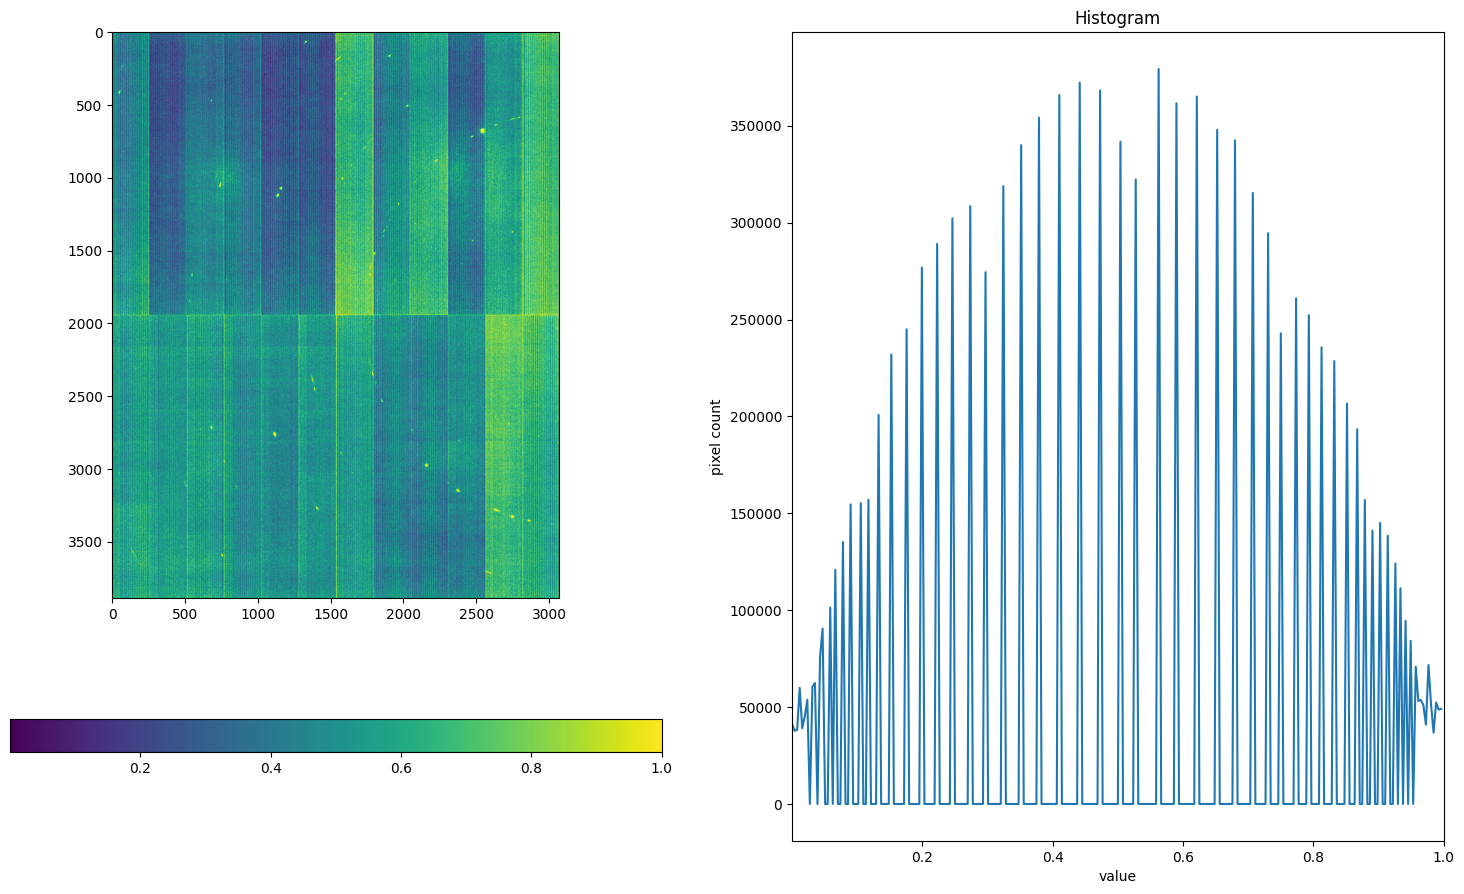

In [8]:
import os,sys

img=db.read(x=[0,W],y=[0,H],z=[Z,Z+1], num_refinements=1)[0,:,:]
print(img.dtype,img.shape)
ShowImage(exposure.equalize_hist(img))

# Show coarse to fine

dtype float64 shape (486, 384) m 1.071673525377229e-05 M 1.0
dtype float64 shape (972, 1536) m 6.697959533607681e-07 M 1.0
dtype float64 shape (3888, 3072) m 8.372449417009602e-08 M 1.0


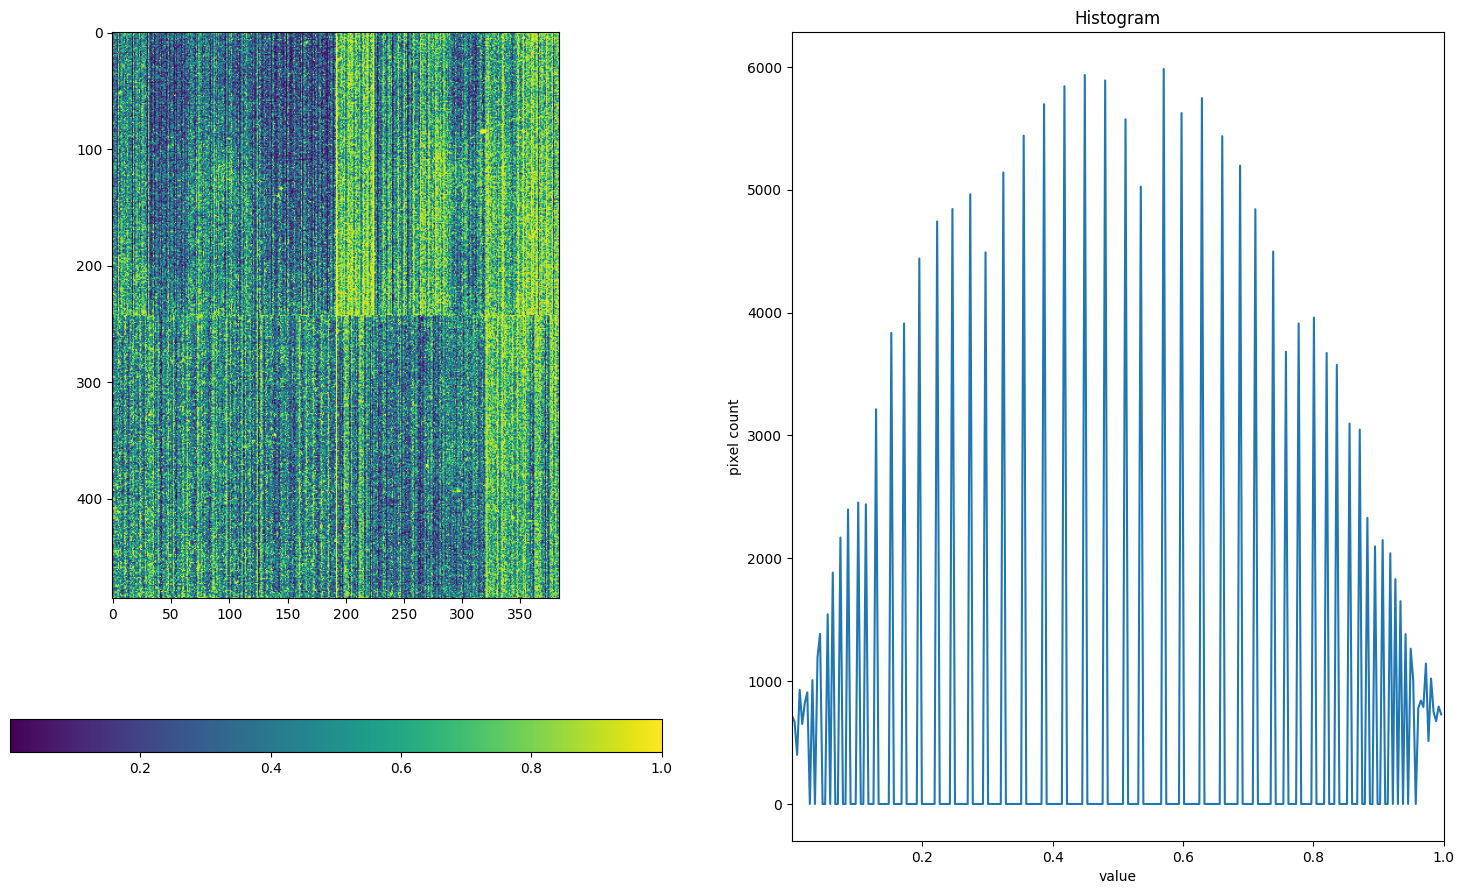

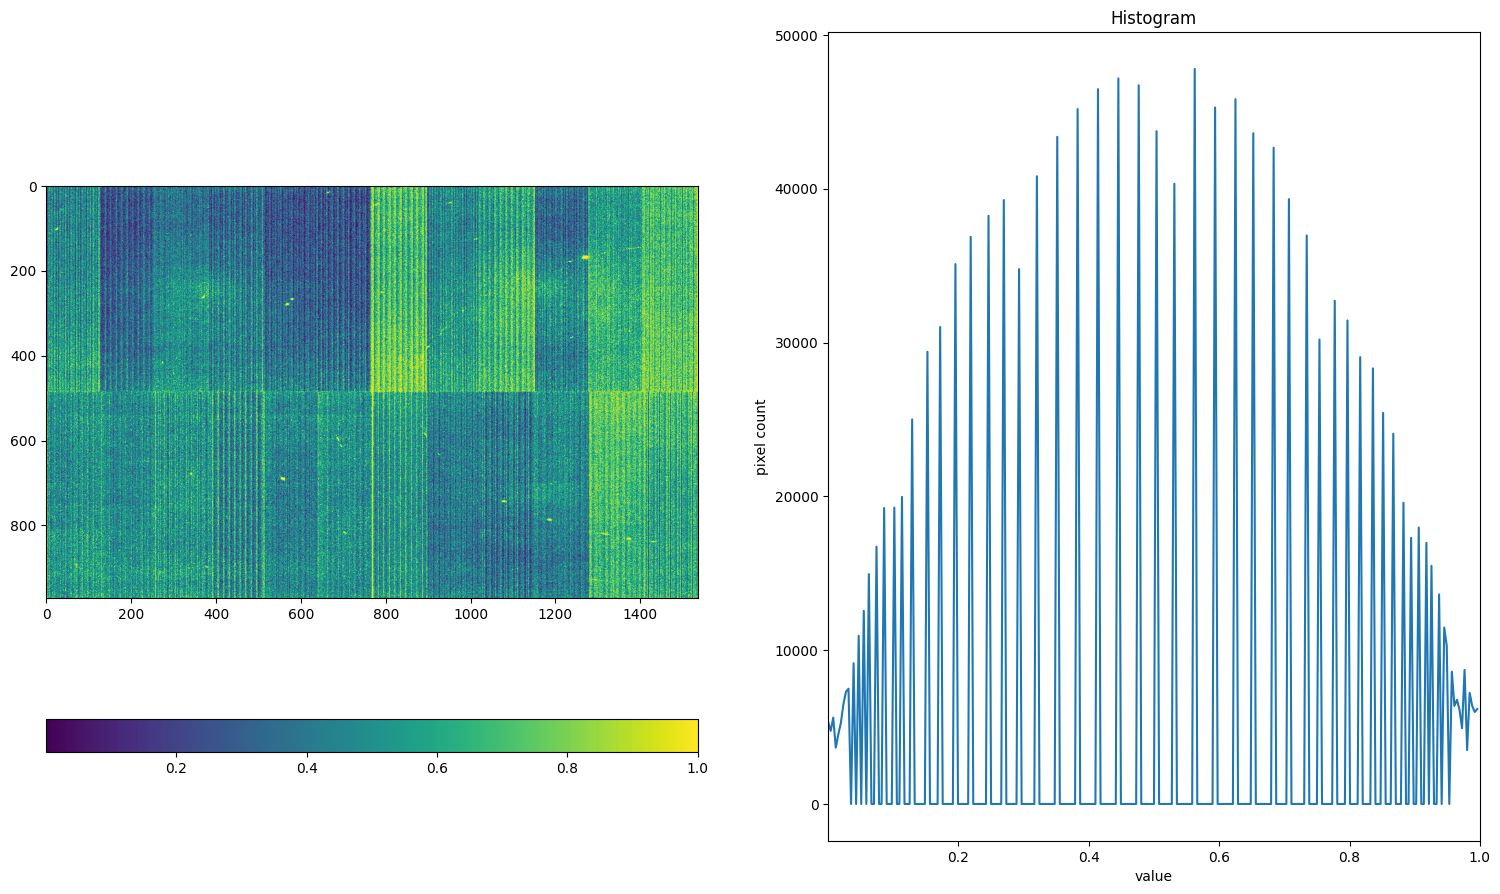

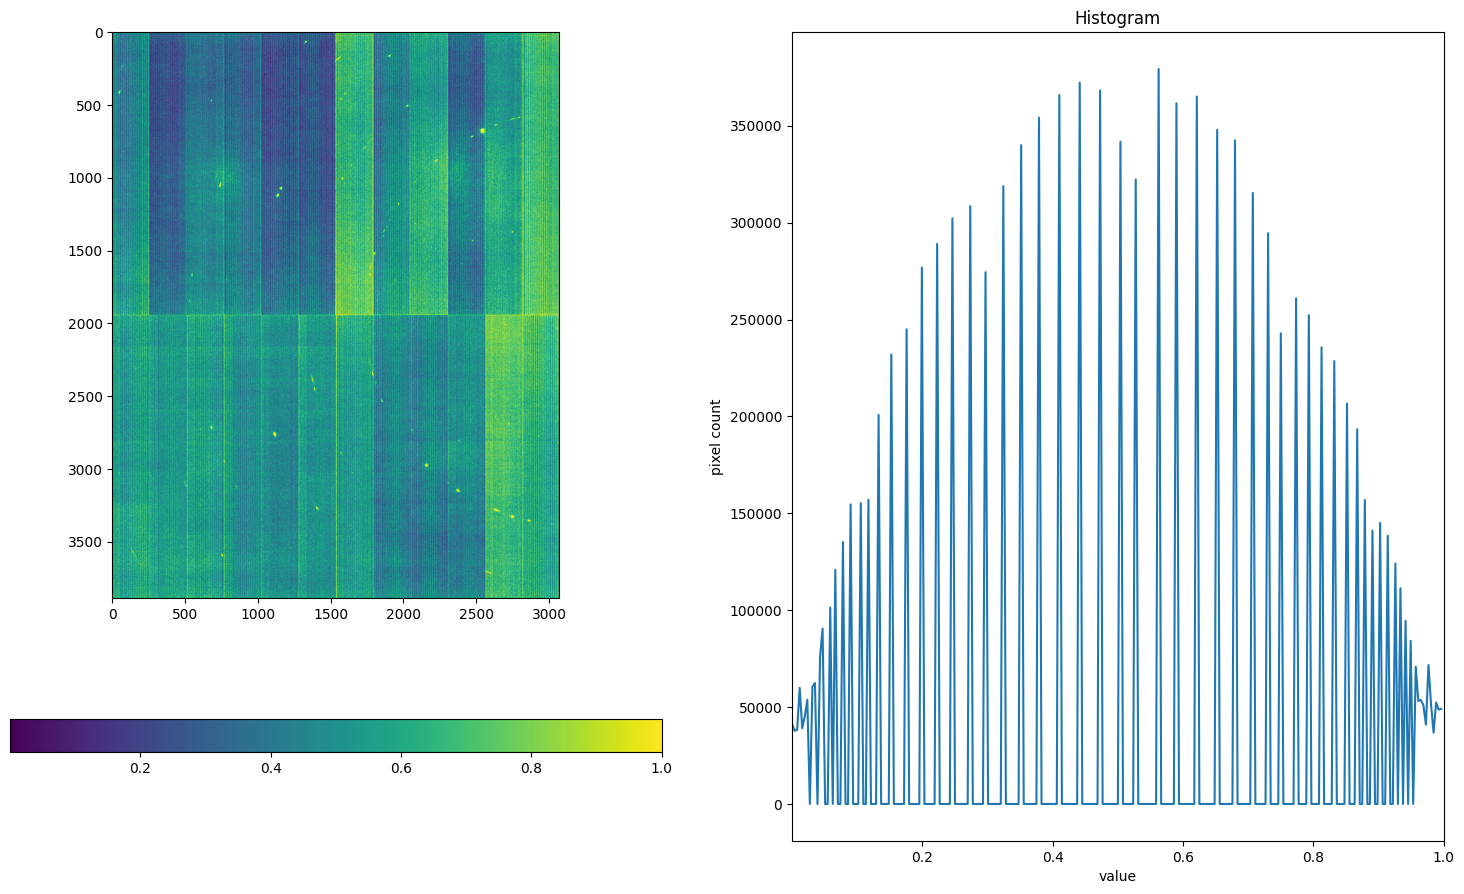

In [10]:
import os,sys
for img in db.read(x=[0,W],y=[0,H],z=[Z,Z+1], num_refinements=3):
	ShowImage(exposure.equalize_hist(img[0,:,:]))